# Notebook 2: Short, Long and Auxiliary Linear Regression
_Bryan Graham - University of California - Berkeley_

(with assistance from Seongjoo Min)

_Ec 240a: Econometrics, Fall 2016_




Class lectures have emphasized the various iteration properties of linear predictors. In this notebook we will use the subsample of white male NLSY79 respondents featured in Notebook 1 to concretely illustrate the sample analogs of these properties.
<br>
<br>
We will consider the "long" least squares fit of log earnings onto a constant, years of completed schooling and AFQT percentile score. We will show that the coefficient on schooling in the "short" least squares fit of log earnings onto a constant and years of completed schooling alone can be recovered from a combination of the "long" fit and the "auxiliary" least squares fit of AFQT onto a constant and years of completed schooling. This provides a concrete illustration of what is sometimes called the "omitted variable bias" formula in econometrics textbooks. I would like to emphasize that I dislike that terminology. A more insightful framing of the result is as a consequence of the law-of-iterated linear predictors.
<br>
<br>
We then turn to an illustration of the Frisch-Waugh Theorem. Specifically we show that that the coefficient on schooling in the "long" least squares fit can be recovered from the least squares fit of log earnings onto a certain residual. More specifically we compute the least squares fit of schooling onto a constant and AFQT score. We then compute the vector of residuals associated with this fit. This provides the component of years of completed schooling that is uncorrelated with AFQT scores. Finally we compute the least squares fit of log earnings onto these residuals (excluding the constant term). The coefficient on these residuals numerically coincides with the coefficient on schooling in the long regression fit. This is the Frisch-Waugh result.
<br>
<br>
The residual regression result has a variety of computational uses (it arises frequently in panel data analysis), and also provides insight into how conditioning on additional control variables affects the coefficient on the variable of interest in the context of linear regression analysis. It can also help in your understanding of more complex methods of covariate adjustment, as in the, for example, the partially linear model.
<br>
<br>
The notebook ends by providing an illustration of the so-called Bayesian Bootstrap. The Bayesian Bootstrap is a method of drawing from a particular posterior distribution for our linear predictor coefficients. We motivate and develop this approach later in the course.

In [1]:
# Direct Python to plot all figures inline (i.e., not in a separate window)
%matplotlib inline

# Load libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
from __future__ import division

We begin by loading the subsample of white male NLSY79 respondents used in Notebook 1.

In [3]:
# Directory where nlsy79.csv file (created in Ec240a Python Notebook 1) is located
workdir =  '/Users/bgraham/Dropbox/Teaching/Berkeley_Courses/Ec240a/Ec240a_Fall2016/Python/'

In [4]:
# Read in NLSY79 Extract
nlsy79 = pd.read_csv(workdir+'nlsy79.csv') # Reading .csv as DataFrame

# Hierarchical index: household, then individual; keep indices as columns too
nlsy79.set_index(['HHID_79','PID_79'], drop=False)

# Display the first few rows of the dataframe
nlsy79.head()

,Unnamed: 0,PID_79,HHID_79,year_born,Earnings,HGC_Age28,AFQT
0,5,6,5,60,57623.856667,16.0,99.392998
1,6,7,7,64,34636.081000,12.0,47.411999
2,8,9,9,63,48700.858250,14.0,59.682999
3,12,13,13,58,56102.037000,16.0,72.313004
4,14,15,15,64,0.000000,16.0,82.260002


Our linear regression analysis will use log earnings. A long literature in labor economics documents that average log earnings are approximately linear in years of completed schooling. A consequence of working with log earnings as our outcome variable is that we will need to confine our analysis to NLSY respondents with non-zero earnings. This further reduces the size of our sample (from 1,969 to 1,906). Recall that our target subsample included 2,439 respondents

In [5]:
# Drop units with zero earnings (will evaluate to -Inf by np.log) and compute log earnings
nlsy79 = nlsy79[nlsy79.Earnings!=0]
nlsy79['LogEarn'] = np.log(nlsy79.Earnings) # Log earnings

# Only return earnings, schooling and AFQT variables
nlsy79 = nlsy79[["PID_79","HHID_79","LogEarn","HGC_Age28","AFQT"]] 
nlsy79.describe()

,PID_79,HHID_79,LogEarn,HGC_Age28,AFQT
count,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000
mean,3379.155824,3365.458552,10.754122,13.303253,55.674604
std,2549.500860,2528.404739,0.942789,2.486786,28.489772
min,6.000000,5.000000,1.878594,7.000000,0.000000
25%,1582.750000,1579.750000,10.399056,12.000000,31.700499
50%,3126.000000,3124.000000,10.832781,12.000000,58.341002
75%,4639.000000,4635.250000,11.242632,16.000000,80.109503
max,12139.000000,12137.000000,12.660816,20.000000,100.000000


We begin our analysis by computing the least squares fit of log earnings onto a constant and years of completed schooling (i.e., the short regression). We will use the implementation of OLS found in the statsmodels library. Documentation for this library as well as a variety of code examples can be found at http://statsmodels.sourceforge.net/#.

In [6]:
y    = nlsy79['LogEarn'] 
X    = nlsy79['HGC_Age28']
W    = nlsy79['AFQT']
XW   = nlsy79[['HGC_Age28','AFQT']]

# Short regression: OLS fit of log earnings on years of schooling
# Use White's (1980) heteroscedastic robust variance-covariance estimator
short_reg=sm.OLS(y,sm.add_constant(X)).fit(cov_type='HC0')
print '------------------------------------------------------------------------------'
print '- Model SR : Short Regression                                                 -'
print '------------------------------------------------------------------------------'
print ''
print(short_reg.summary())


------------------------------------------------------------------------------
- Model SR : Short Regression                                                 -
------------------------------------------------------------------------------

                            OLS Regression Results                            
Dep. Variable:                LogEarn   R-squared:                       0.184
Model:                            OLS   Adj. R-squared:                  0.183
Method:                 Least Squares   F-statistic:                     417.6
Date:                Wed, 02 Nov 2016   Prob (F-statistic):           4.49e-84
Time:                        09:12:11   Log-Likelihood:                -2398.1
No. Observations:                1906   AIC:                             4800.
Df Residuals:                    1904   BIC:                             4811.
Df Model:                           1                                         
Covariance Type:                  HC0             

Our OLS fit suggests that schooling is a strong (linear) predictor of log earnings. Imagine we drew two individuals at random (from the population of employed white males born between 1957 and 1964 and resident in the United States in 1979) and observed that one of these individuals had completed college, while the second had competed only high school. What should our prediction of the earnings gap between these two individuals be? Our OLS fit suggests using the prediction $4\times 0.16\times 100 = 64$ percent.
<br>
<br>
The standard error reported in the results table is the one due to White (1980). This standard error provides an estimate of the variability of our coefficient estimate across repeated large samples. We will motivate this measure of uncertaintly and derive it formally later in the course.
<br>
<br>
Next we compute the long least squares fit of log earnings onto a constant, schooling and AFQT score percentile.

In [7]:
# Long regression: OLS fit of log earnings on years of schooling & AFQT percentile
# Use White's (1980) heteroscedastic robust variance-covariance estimator
long_reg=sm.OLS(y,sm.add_constant(XW)).fit(cov_type='HC0')
print '------------------------------------------------------------------------------'
print '- Model LR : Long Regression                                                  -'
print '------------------------------------------------------------------------------'
print ''
print(long_reg.summary())

------------------------------------------------------------------------------
- Model LR : Long Regression                                                  -
------------------------------------------------------------------------------

                            OLS Regression Results                            
Dep. Variable:                LogEarn   R-squared:                       0.209
Model:                            OLS   Adj. R-squared:                  0.208
Method:                 Least Squares   F-statistic:                     217.8
Date:                Wed, 02 Nov 2016   Prob (F-statistic):           6.50e-86
Time:                        09:12:13   Log-Likelihood:                -2367.9
No. Observations:                1906   AIC:                             4742.
Df Residuals:                    1903   BIC:                             4758.
Df Model:                           2                                         
Covariance Type:                  HC0             

Additionally conditioning on AFQT changes the coefficient of schooling quite a bit (from 0.16 to 0.11). If our two randomly drawn individuals also happened to have identical AFQT scores (and we observed this coincidence), then our long regression fit suggests that our predicted earnings gap should only be $4\times 0.11\times 100 = 44$ percent.
<br>
<br>
Why are the predictions associated with the short and long regression coefficients different? The coefficient on schooling in the short regression reflects the fact that the distribution of AFQT differs systematically across subpopulations defined in terms of schooling. We can see this more concretely by computing the auxiliary regression of schooling onto a constant and AFQT score.

In [8]:
# Auxiliary linear regression: OLS fit of AFQT on years of schooling
# Use White's (1980) heteroscedastic robust variance-covariance estimator
aux_reg=sm.OLS(W,sm.add_constant(X)).fit(cov_type='HC0')
print '------------------------------------------------------------------------------'
print '- Model AR : Model with years of schooling alone & AFQT dummies               -'
print '------------------------------------------------------------------------------'
print ''
print(aux_reg.summary())

------------------------------------------------------------------------------
- Model AR : Model with years of schooling alone & AFQT dummies               -
------------------------------------------------------------------------------

                            OLS Regression Results                            
Dep. Variable:                   AFQT   R-squared:                       0.443
Model:                            OLS   Adj. R-squared:                  0.443
Method:                 Least Squares   F-statistic:                     2252.
Date:                Wed, 02 Nov 2016   Prob (F-statistic):               0.00
Time:                        09:12:14   Log-Likelihood:                -8530.8
No. Observations:                1906   AIC:                         1.707e+04
Df Residuals:                    1904   BIC:                         1.708e+04
Df Model:                           1                                         
Covariance Type:                  HC0             

The auxiliary least squares fit confirms that AFQT varies systematically with schooling. Specifically we would predict a AFQT percentile gap between a college and high school graduate of $4\times 7.6 = 30.4$ percent. If AFQT also helps to (linearly) predict earnings (which the long regression fit suggests it does), then the coefficient on schooling in the short and long fits will differ.
<br>
<br>
Using the law of iterated linear predictors we have that the short regression coefficient on schooling should equal the long regression coefficient plus the product of the auxiliary regression coefficient on schooling times the long regression coefficient on AFQT: $0.1626 = 0.1086 + 7.6237\times 0.0071 = 0.1626$
<br>
<br>
We next compute the residual regression, illustrating the Frish-Waugh Theorem.

In [9]:
# Residual linear regression: OLS fit of log earnings on (residualized) years of schooling

# Auxiliary regression of years of schooling onto AFQT; save residuals
aux_reg=sm.OLS(X,sm.add_constant(W)).fit(cov_type='HC0')
V = pd.DataFrame({'Res_HGC':aux_reg.resid})

# Compute residual regression
res_reg=sm.OLS(y,V,hasconst=False).fit(cov_type='HC0')
print '------------------------------------------------------------------------------'
print '- Model RR : Residual regression of earnings onto (residualized) schooling   -'
print '------------------------------------------------------------------------------'
print ''
print(res_reg.summary())

------------------------------------------------------------------------------
- Model RR : Residual regression of earnings onto (residualized) schooling   -
------------------------------------------------------------------------------

                            OLS Regression Results                            
Dep. Variable:                LogEarn   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.6561
Date:                Wed, 02 Nov 2016   Prob (F-statistic):              0.418
Time:                        09:12:16   Log-Likelihood:                -7238.8
No. Observations:                1906   AIC:                         1.448e+04
Df Residuals:                    1905   BIC:                         1.449e+04
Df Model:                           1                                         
Covariance Type:                  HC0              

The Frish-Waugh Theorem provides insight into the effect of conditioning in the linear regression context. The coefficient on schooling in the long regression reflects the covariance between log earnings and that component of schooling _which is uncorrelated with_ the additional included/auxiliary variables.
<br>
<br>
We end our notebook with a snippet of code which implements the Bayesian Bootstrap. You can read more about this procedure in Chamberlain and Imbens (2003, _Journal of Business and Economic Statistics_). We will develop this resampling procedure more carefully later in the course. Mechanically it generates an estimate of the posterior distribution of our long linear regression coefficients by repeated computation of the least squares fit using different random perturbations of our sample. The code provides an illustration of how to construct a "for loop" in Python and also illustrates more of the graphing capabilities of the matplotlib library and its seaborn add-on.
<br>
<br>
An interesting question is how the "degree-of-belief" motivated posterior distribution generated by the Bayesian Bootstrap relates to the asymptotically normal repeated sampling distribution?



BAYESIAN BOOTSTRAP RESULTS
2.5, 5, 50, 95, 97.5 Percentiles
           Ratio  Return-to-AFQT  Return-to-Schooling
0.025  10.153246        0.005088             0.089684
0.050  10.821158        0.005396             0.092573
0.500  15.304595        0.007074             0.108526
0.950  22.084119        0.008832             0.124771
0.975  24.085473        0.009223             0.128003
Summary Statistics
              Ratio  Return-to-AFQT  Return-to-Schooling
count  10000.000000    10000.000000         10000.000000
mean      15.808894        0.007080             0.108531
std        3.531836        0.001043             0.009693
min        6.737129        0.003506             0.075302
25%       13.367922        0.006365             0.102153
50%       15.304595        0.007074             0.108526
75%       17.772679        0.007764             0.114943
max       40.340843        0.012060             0.142232


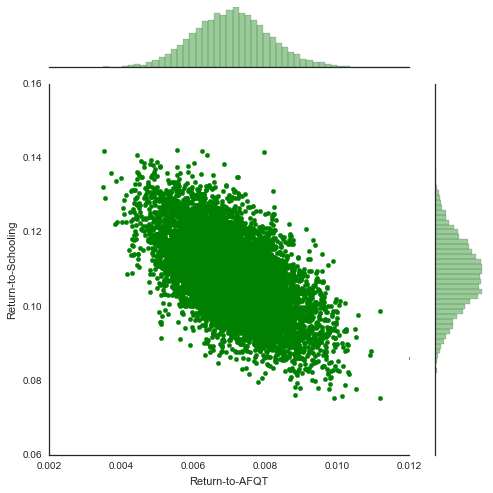

In [10]:
##############################################################################
# Bayesian Bootstrap (cf., Chamberlain and Imbens (2003, JBES))              #
##############################################################################

XW = sm.add_constant(XW) # "Permanently" add constant to design matrix

B = 10000                # Number of posterior draws
M = np.empty((B,3))      # Matrix with posterior draws of statistics of interest
N = len(y)               # Number of observations in dataset

for b in range (0,B):
    W = np.random.gamma(1.,1.,N) # Random draws of Gamma(1,1) variables
    W = W/np.sum(W)              # Converting draws to Dirichlet 
    
    result = sm.WLS(y,XW,weights=W).fit()
    M[b,:] = np.matrix(result.params) # Linear regression with Dirichlet wgts
    M[:,0] = M[:,1]/M[:,2]            # Replacing the constant coefficient with
                                      # ratio of school-to-AFQT coefficients

# Put Bayesian Bootstrap results in a pandas dataframe        
BB=pd.DataFrame({'Ratio':M[:,0], 'Return-to-Schooling':M[:,1], 'Return-to-AFQT':M[:,2]})

# Scatter (use seaborn add-on to matplotlib)
sns.set(style="white")
sns.jointplot("Return-to-AFQT","Return-to-Schooling", data=BB, kind="scatter", \
                        size=7, space=0, color="g", xlim=(0.002,0.012), ylim=(0.06,0.16), stat_func=None)

# Save result
plt.tight_layout()
plt.savefig(workdir+'BayesBootstrap_Fig1.png', bbox_inches='tight', dpi=500)

print '\n'
print '======================================================================='
print 'BAYESIAN BOOTSTRAP RESULTS'
print '======================================================================='
print '2.5, 5, 50, 95, 97.5 Percentiles'
print '=======================================================================' 
print BB.quantile(q=[0.025, 0.05, 0.5, 0.95, 0.975])
print '======================================================================='
print 'Summary Statistics'
print '======================================================================='
print BB.describe() 
print '======================================================================='

del y, X, XW, B, M, N, result

The figure above suggests that the posterior distribution of the linear predictor coefficients on schooling and AFQT could be well approximated by a bivariate normal distribution.
<br>
<br>
How about the distribution of the ratio of the schooling and AFQT coefficients? This distribution is depicted in the histogram below. Here we see that a normal approximation may be less accurate. Specifically it would fail to capture the right-skewness of the posterior.

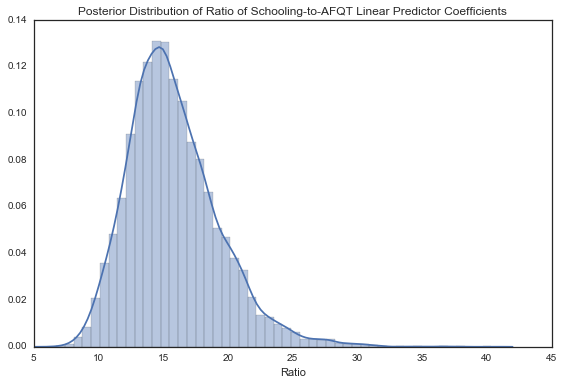

In [11]:
# Histogram of coefficient ratio
sns.distplot(BB['Ratio']);
plt.title("Posterior Distribution of Ratio of Schooling-to-AFQT Linear Predictor Coefficients")

# Save result
plt.tight_layout()
plt.savefig(workdir+'BayesBootstrap_Fig2.png', bbox_inches='tight', dpi=500)

In [12]:
# This imports an attractive notebook style from Github
from IPython.core.display import HTML
import urllib2
HTML(urllib2.urlopen('http://bit.ly/1Bf5Hft').read())